# Churn Prediction System

## Latar Belakang

Pada Industri Telekomunikasi, Customer churn (Berhenti Berlangganan) jadi masalah utama, rata rata churn 15-25%.

kerugiannya dari menarik pelanggan baru 5-10x lebih mahal dari pada menjaga yang lama

Dengan simple math. kita bisa simpulin, kalo perusahaan dengan 1 juta pelanggan. dan APRU(Average Revenue Per User) $50. kalau churnya 25%. maka pendapatan bisa hilang sampai $200 jt per tahun.

Customer Lifetime Value (CLTV) digunakan sebagai pengukuran kesehatan bisnis jangka panjang. penurunan churn sekecil 1% bisameningkatkan laba sampe 5%. kalo 5%, profit bisa naik sampe 50%. the point is. strategi mempertahankan ini punya ROI yang sangat tinggi.

Sebenarnya, churn bisa mengunkap bahwa ada kesalahan dalam bisnis. churn ningkat kalo layanan emang buruk atau tidak bisa hanle jagnka panjang. 

## Tujuan Projek :

Membangun sistem machine learning untuk prediksi pelanggan yang berisiko churn. dan juga mengunkap alasan di baliknya. Hasil analisis ini diharapkan bisa mendukung stratefi retensi yang efisien.

## Dataset :

https://www.kaggle.com/datasets/blastchar/telco-customer-churn?utm_source=chatgpt.com

dataset yang digunakan adalah Telco Customer Churn dari kaggle, metodologi dari eda sampai deployment.

In [28]:
# Import library yang dibutuhkan
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from IPython.display import display

# Konfigurasi visualisasi
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Library untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Mengabaikan warning untuk kebersihan output
import warnings
warnings.filterwarnings('ignore')

## EDA (Exploratory Data Analysis)

mahamin pola, merumuskan hipotesis awal, cek validasi data.

### Datasets

In [8]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)
print(f"File yang tersedia:{os.listdir(path)}")

Path to dataset files: /Users/ryanakmalpasya/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1
File yang tersedia:['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [9]:
# Membaca dataset
df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Menampilkan 5 baris pertama
print("Data Awal:")
display(df.head())

# Menampilkan info dasar dataset
print("\nInformasi Dataset:")
df.info()

Data Awal:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

### Datasets Overview

| Kolom                | Deskripsi                                                                 |
|----------------------|---------------------------------------------------------------------------|
| `customerID`         | ID unik untuk setiap pelanggan. Tidak berguna untuk model prediktif.      |
| `gender`             | Jenis kelamin pelanggan: `Male` atau `Female`.                            |
| `SeniorCitizen`      | Apakah pelanggan adalah warga senior (1 = Ya, 0 = Tidak).                 |
| `Partner`            | Apakah pelanggan memiliki pasangan (married).                             |
| `Dependents`         | Apakah pelanggan memiliki tanggungan (anak/orang tua).                    |
| `tenure`             | Lama pelanggan berlangganan (dalam bulan).                                |
| `PhoneService`       | Apakah pelanggan memiliki layanan telepon.                                |
| `MultipleLines`      | Apakah pelanggan memiliki lebih dari satu saluran telepon.                |
| `InternetService`    | Jenis layanan internet: `DSL`, `Fiber optic`, atau `No`.                  |
| `OnlineSecurity`     | Apakah pelanggan memiliki layanan keamanan online.                        |
| `OnlineBackup`       | Apakah pelanggan memiliki layanan backup online.                          |
| `DeviceProtection`   | Apakah pelanggan memiliki perlindungan perangkat.                         |
| `TechSupport`        | Apakah pelanggan memiliki dukungan teknis.                                |
| `StreamingTV`        | Apakah pelanggan berlangganan streaming TV.                               |
| `StreamingMovies`    | Apakah pelanggan berlangganan streaming film.                             |
| `Contract`           | Jenis kontrak: `Month-to-month`, `One year`, `Two year`.                  |
| `PaperlessBilling`   | Apakah pelanggan menggunakan tagihan tanpa kertas.                        |
| `PaymentMethod`      | Metode pembayaran: misalnya `Electronic check`, `Credit card`, dll.       |
| `MonthlyCharges`     | Jumlah tagihan bulanan pelanggan.                                         |
| `TotalCharges`       | Total tagihan yang dibayar selama menjadi pelanggan. (Perlu konversi)     |
| `Churn`              | Target variabel: apakah pelanggan berhenti (`Yes`) atau tetap (`No`).     |

In [10]:
df['bin']

KeyError: 'bin'

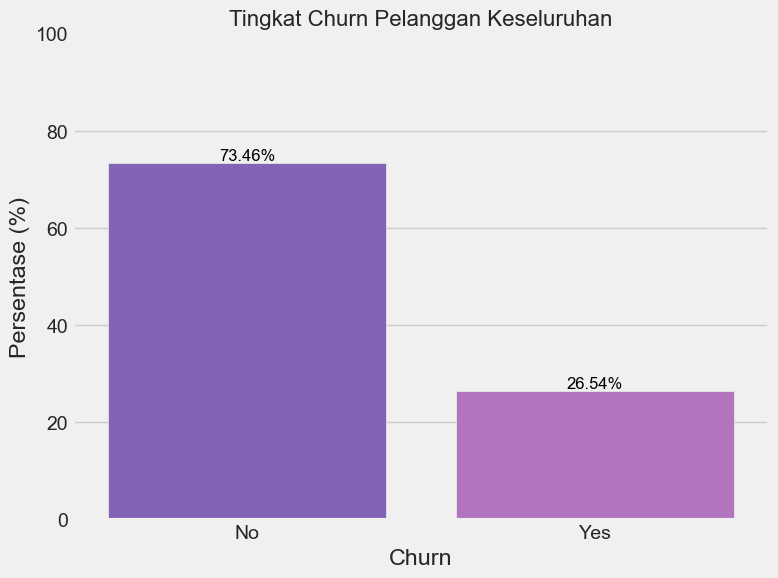

Tingkat Churn:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [11]:
# Menghitung dan memvisualisasikan tingkat churn
churn_rate = df['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, palette = ['#7E57C2', '#BA68C8'])
plt.title('Tingkat Churn Pelanggan Keseluruhan', fontsize=16)
plt.ylabel('Persentase (%)')
plt.xlabel('Churn')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.ylim(0, 100)
plt.show()

print(f"Tingkat Churn:\n{churn_rate}")

**Analisis :** 

Sekitar 26.54% pelanggan telah churn. Ini merupakan tingkat churn yang signifikan dan mengonfirmasi bahwa dataset ini tidak seimbang (imbalanced). Ketidakseimbangan ini menjadi pertimbangan krusial yang akan memengaruhi strategi pemodelan dan metrik evaluasi kita.


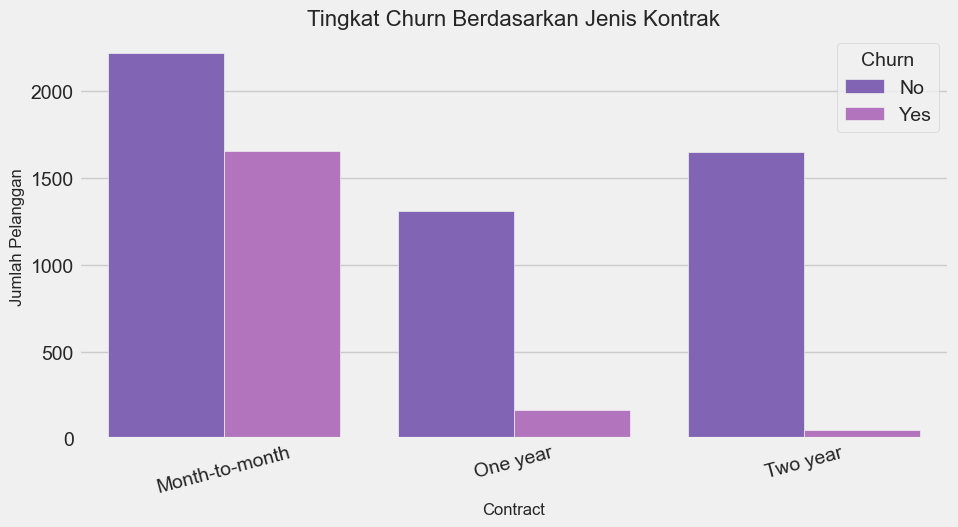

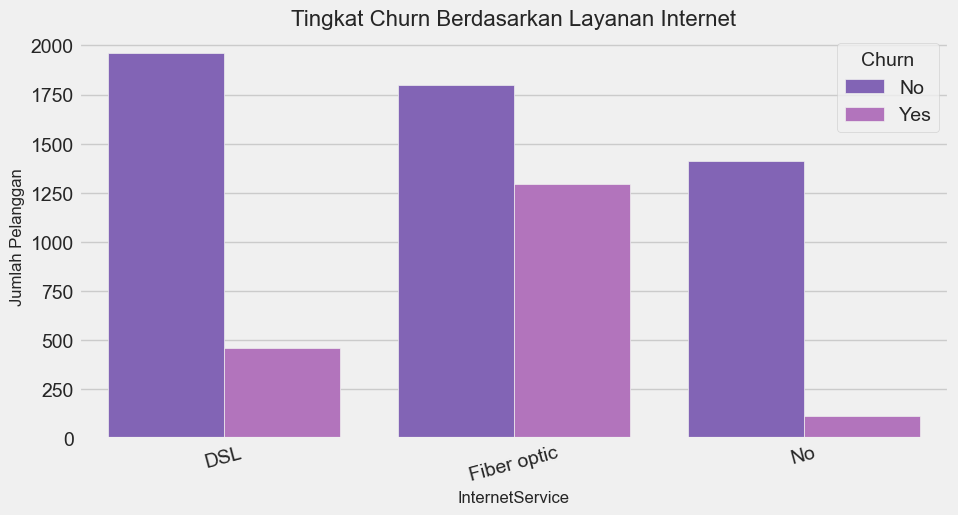

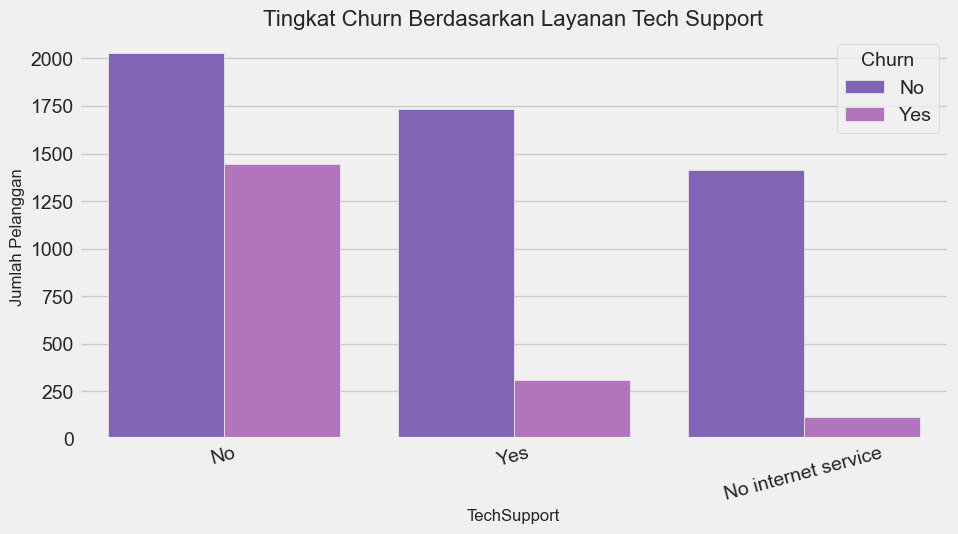

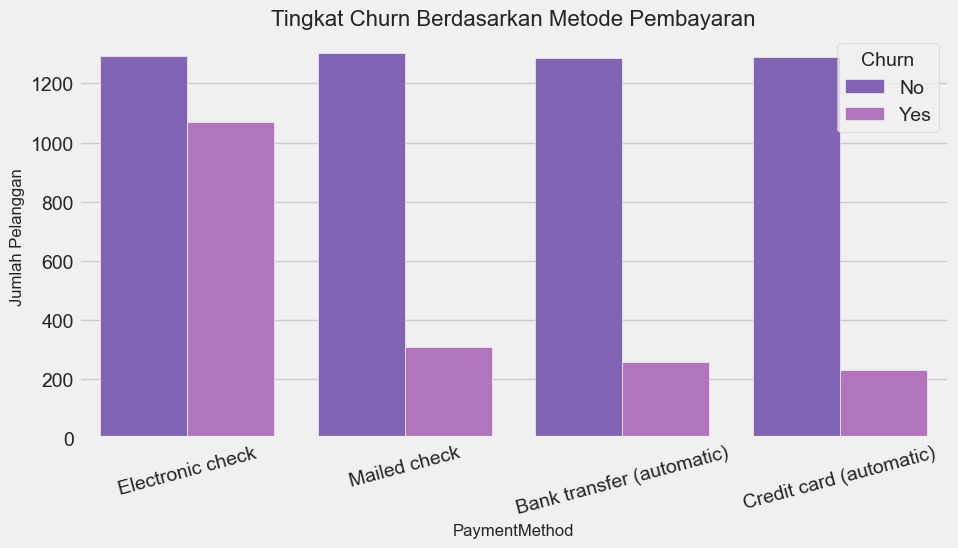

In [12]:
# Fungsi untuk membuat plot fitur kategorikal vs churn
def plot_categorical_vs_churn(feature, title):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=feature, hue='Churn', data=df, palette = ['#7E57C2', '#BA68C8'])
    plt.title(title, fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Jumlah Pelanggan', fontsize=12)
    plt.xticks(rotation=15)
    
    # Hitung persentase churn (Yes) untuk setiap kategori
    churn_percent = df[df['Churn'] == 'Yes'].groupby(feature).size() / df.groupby(feature).size() * 100
    churn_percent = churn_percent.round(1)

    # Tambahkan anotasi persentase churn di atas bar
    for p in ax.patches:
        category = p.get_x() + p.get_width() / 2
        height = p.get_height()
        if p.get_label() == 'Churn=Yes':
            cat_idx = int(p.get_x() + p.get_width() / 2)
            plt.text(category, height + 5, f'{int(height)}', ha='center', fontsize=10)

    plt.legend(title='Churn')
    plt.show()
    
# Visualisasi untuk fitur-fitur penting
plot_categorical_vs_churn('Contract', 'Tingkat Churn Berdasarkan Jenis Kontrak')
plot_categorical_vs_churn('InternetService', 'Tingkat Churn Berdasarkan Layanan Internet')
plot_categorical_vs_churn('TechSupport', 'Tingkat Churn Berdasarkan Layanan Tech Support')
plot_categorical_vs_churn('PaymentMethod', 'Tingkat Churn Berdasarkan Metode Pembayaran')

**Analisis :**

Jenis Kontrak (Contract): Pelanggan dengan kontrak Month-to-month memiliki tingkat churn yang sangat tinggi (42.7%) dibandingkan dengan kontrak One year (11.3%) dan Two year (2.8%). Insight : *Komitmen jangka panjang adalah faktor retensi yang kuat*

Layanan Internet (InternetService): Pelanggan dengan layanan Fiber optic memiliki tingkat churn tertinggi (41.9%). Pelanggan tanpa layanan internet memiliki tingkat churn yang sangat rendah (7.4%). Insight : Masalah pada kualitas layanan fiber optic, mungkin harga ga sepadan dengan layanan.

Layanan Tambahan (Contoh: TechSupport): Pelanggan yang tidak berlangganan layanan tambahan seperti TechSupport (tingkat churn 41.6%) atau OnlineSecurity (tingkat churn 41.8%, tidak ditampilkan) jauh lebih mungkin untuk churn. Insight : layanan ini lebih mengikat pelanggan untuk menggunakan layanan internet.

Metode Pembayaran (PaymentMethod): Pelanggan yang menggunakan Electronic check sebagai metode pembayaran menunjukkan tingkat churn yang jauh lebih tinggi (45.3%) dibandingkan metode pembayaran otomatis seperti transfer bank atau kartu kredit. Insight : Metode pembayaran elektronik cenderung lebih berisiko untuk churn, mungkin karena kesulitan dalam transaksi atau kebingungan dalam pembayaran. atau metode tradisional lebih fleksibel dan kasih kesempatan untuk pelanggan mempertimbangkan kembali layanan mereka.


### Analisis Fitur Numerik

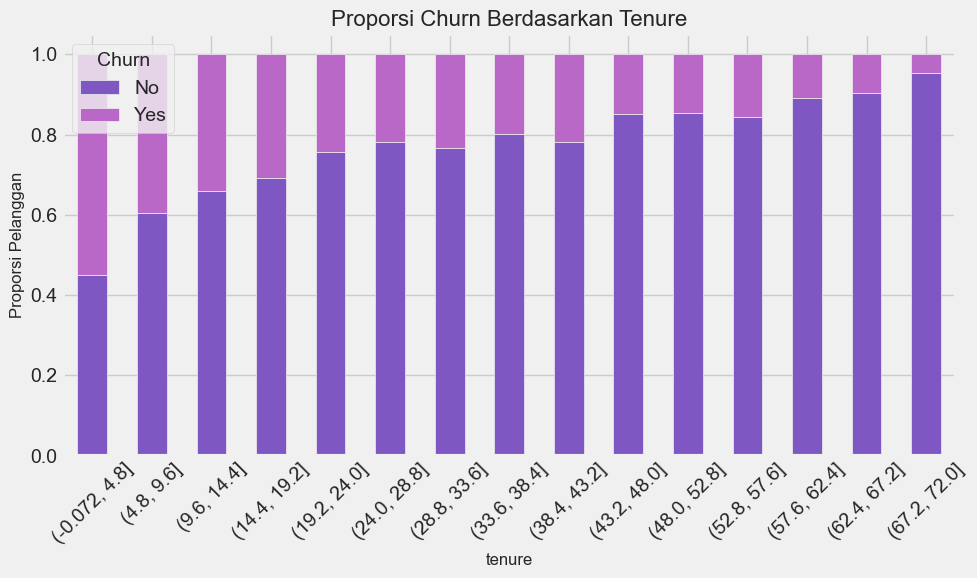

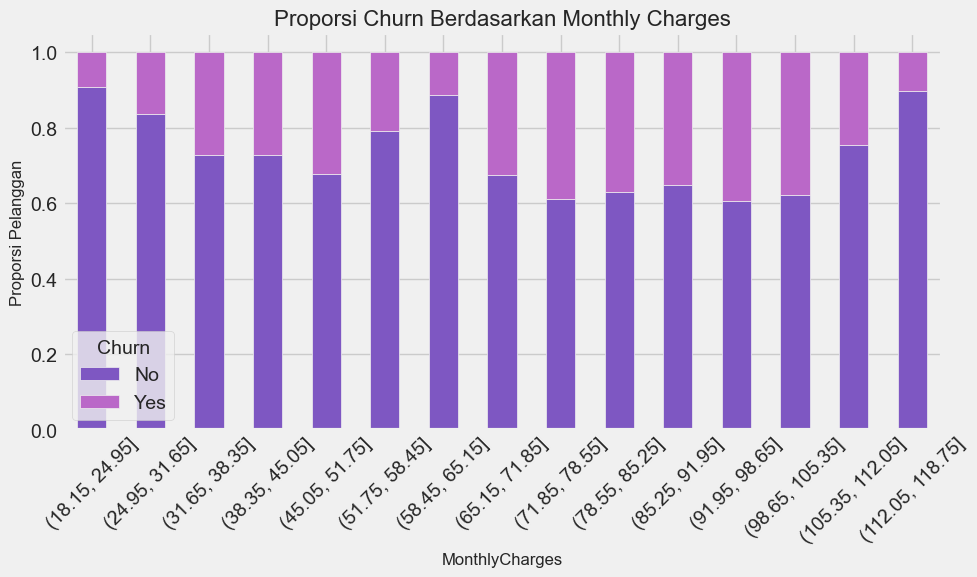

In [13]:
def plot_churn_ratio(feature, title, bins=10):
    # Binning lokal (tidak ubah df)
    binned = pd.cut(df[feature], bins=bins)

    # Gabungkan sementara dengan kolom Churn
    temp_df = pd.DataFrame({'bin': binned, 'Churn': df['Churn']})

    # Hitung proporsi churn per bin
    churn_rate = temp_df.groupby('bin')['Churn'].value_counts(normalize=True).unstack().fillna(0)

    # Plot
    churn_rate.plot(kind='bar', stacked=True, color=['#7E57C2', '#BA68C8'], figsize=(10,6))
    plt.title(title, fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Proporsi Pelanggan', fontsize=12)
    plt.legend(title='Churn', labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualisasi proporsi churn
plot_churn_ratio('tenure', 'Proporsi Churn Berdasarkan Tenure', bins=15)
plot_churn_ratio('MonthlyCharges', 'Proporsi Churn Berdasarkan Monthly Charges', bins=15)

**Analisis :**

Pelanggan <10 bulan paling banyak churn. setelah 10 bulan, churn turun drastis. Insight : Ini merupakn fitur penting penentu churn.

Monthly charges yang menagalami churn tertinggi ada pada tagihan bulanan di antara $70-$100. Insight : golongan menengah atau kaum mendang mending kebanyakan mikir.

### Analisis Korelasi

Heatmap korelasi membantu kita memahami hubungan antar fitur numerik dan mengidentifikasi potensi multikolinearitas.

In [14]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')

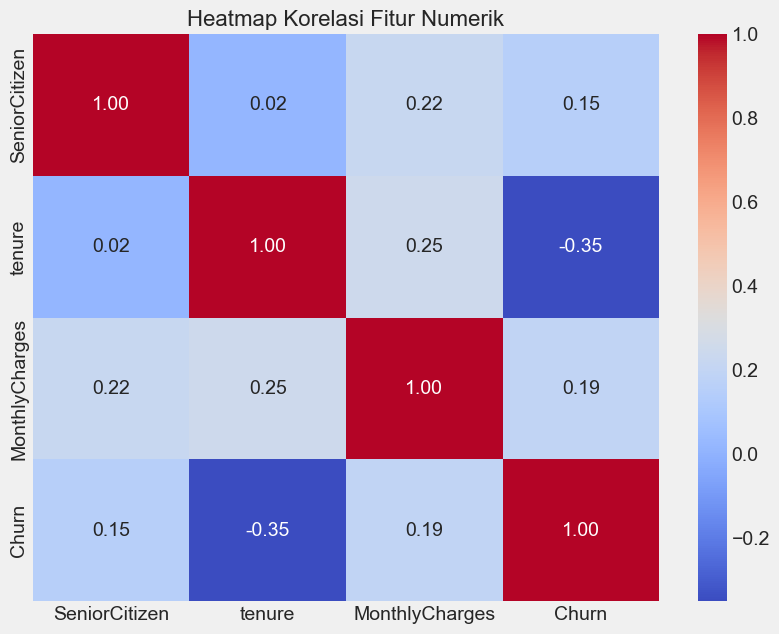

In [15]:
# Mengubah 'Churn' menjadi numerik untuk korelasi
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# Menghitung matriks korelasi
plt.figure(figsize=(9,7))
# Mengonversi kolom non-numerik yang relevan
numeric_cols = df_corr.select_dtypes(include=np.number).columns
correlation_matrix = df_corr[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=16)
plt.show()

fitur numerik kita ada ['SeniorCitizen', 'tenure', 'MonthlyCharges']. kita cek korelasinya dengan label target Churn.

Tenure yang merupakan lama pelanggan berlangganan per bulannya. menunjukkan korelasi negatif terhadap churn (-0.35) - semqkin lama pelanggan bertahan, semakin kecil kemungkinan mereka churn.  

MonthlyCharges yang merupakan tagihan bulanan yang dibayarkan oleh pelanggan. menunjukkan korelasi positif terhadap churn (0.19) - semakin besar tagihan bulanan, semakin besar kemungkinan mereka churn.

SeniorCitizen yang merupakan pelanggan yang berumur 65 tahun ke atas. menunjukkan korelasi negatif terhadap churn (-0.15) - semakin tua usia pelanggan, semakin kecil kemungkinan mereka churn.

Insight : Fitur numerik berpengaruh ke chrun adalah tanure dan MonthlyCharges.


### Hipotesis Awal :

H1 : Pelanggan yang tidak terlalu terikat dengan sistem lebih sering churn. pelanggan dengan kontrak bulanan(MonthlyCharges), masa langganan singkat (tanure), serta metode pembayaran manual yang lebih fleksibel untuk berhenti kapan saja. Karena emreka ga terlalu terikat. mereka paling beresiko buat churn

H2 : Pelanggan layanan mahal meraga ga worth it. pelanggan yang pake layanan fiberoptic yang mahal malah lebih banyak churn, artinya kecewa dengan harga yang ga sepadan.

Kesimpulan : Semakin “terikat” pelanggan (pakai kontrak tahunan, bayar otomatis, atau ambil paket bundling), semakin kecil kemungkinan mereka churn. Jadi, strategi retensi sebaiknya fokus ke menciptakan keterikatan ini .misalnya dengan kasih promo untuk upgrade ke kontrak tahunan atau pindah ke pembayaran otomatis.

---

## Data Preprocessing and Feature Engineering

Menghapus kolom yang tidak relevan, null value, dan encoding fitur kategorikal, serta membagi dataset dan membangun pipeline processing.

In [66]:
df_prep.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [17]:
# salin data untuk preprocessing
df_prep = df.copy()

# kolom ga relevan kaya Id idhapus
df_prep = df_prep.drop('customerID', axis=1)

### Handling NNull Values

In [18]:
df_prep.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [19]:
# ubah fitur totalcharges menjadi numerical
df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')

# periksa nilai null setelah transformasi total charges
missing_charges = df_prep[df_prep['TotalCharges'].isnull()]
print("Baris dengan TotalCharges yang hilang:")
display(missing_charges)

Baris dengan TotalCharges yang hilang:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


dalam handle null value, bisa dihapus atau imputasi, tergantung ke validasian dari null itu sendiri, apakah itu sebaiknya memang dihapus atau tidak. berdasarkan data. pada 11 baris null total charges. kita bisa lihat tenure nya 0 dan seniorcitizen juga nol. yang ga masuk akal atau data yang bias dan tidak valid. dan karena jumlah baris nya sedikit. maka dari itu, kita harus hapus baris tersebut

In [20]:
# Menghapus baris dengan nilai yang hilang
df_prep.dropna(inplace=True)

# Memverifikasi bahwa tidak ada lagi nilai yang hilang
print("\nJumlah nilai hilang setelah pembersihan:")
print(df_prep.isnull().sum())


Jumlah nilai hilang setelah pembersihan:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Encode Categorical Feature also Target



In [21]:
# Mengubah target 'Churn' menjadi 0 dan 1
df_prep['Churn'] = df_prep['Churn'].map({'No': 0, 'Yes': 1})

# Mengidentifikasi kolom numerik dan kategorikal
numerical_features = df_prep.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('Churn')  # Hapus target dari daftar fitur

categorical_features = df_prep.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nFitur Numerik:", numerical_features)
print("Fitur Kategorikal:", categorical_features)


Fitur Numerik: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Fitur Kategorikal: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [22]:
print(df_prep[categorical_features].dtypes)

gender              object
Partner             object
Dependents          object
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
dtype: object


Perlu dicatat, proses akan di execute pada pipeline di akhir, dikarenakan kita pake pendekatan pipeline otomatis, dan pake package yang seakan akan melihat isi data. kita harus split datanya dulu sebelum transformasi datanya. supaya keseluruhan data ga keleaked dan ke learning duluan.

### Split Data

Data bakal kita split 8:2. dan kita bakal pake stratify=y untuk pastikan distribusi label yang balance untuk train dan test.

In [23]:
# pisahin fitur dan target
X = df_prep.drop('Churn', axis=1)
y = df_prep['Churn']

# splt data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("\nDistribusi Churn di Training Set:")
print(y_train.value_counts(normalize=True))
print("\nDistribusi Churn di Test Set:")
print(y_test.value_counts(normalize=True))


Distribusi Churn di Training Set:
Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64

Distribusi Churn di Test Set:
Churn
0    0.734186
1    0.265814
Name: proportion, dtype: float64


### Pipeline Preprocessing Automatics

kita bakal pake package ColumnTransformer. Pipeline ini akan menerapkan StandardScaler pada fitur numerik dan OneHotEncoder pada fitur kategorikal. standar scaler dipake untuk mengubah rentang distribusi data menjadi lebih dekat, sehingga tidak menyebabkan gradient explotion pada backpropagation atau update weigth models. one hot encoder, mengubah fitur kategorikal menjadi numerik, 0 dan 1. dan penting untuk pakai drop='first' untuk mencegah multikolinearitas. artinya lebih baik gender(0 dan 1) dari pada gender_pria(0 dan 1) dan gender_wanita(0 dan 1). yang ga bikin pola dari data. sehingga ga ada yang bisa dipelajari oleh modl

In [44]:
# Membuat pipeline untuk transformasi fitur numerik
numeric_transformer = StandardScaler()

# Membuat pipeline untuk transformasi fitur kategorikal
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Menggabungkan transformer menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Memastikan tidak ada kolom yang terlewat
)

# Menampilkan pipeline preprocessing
print("\nPipeline Preprocessing:")
print(preprocessor)


Pipeline Preprocessing:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])


Again, disini kita cuamn set up parameter untuk dipake untuk preprocessing data. pemanggilan fungsi akan dilakuakn sesuai model yang akan diguankan. sehingga pipeline akan dieksekusi sekalian di training model

---

## Models

### Baseline - Logistic Regression

model klasifikasi yang ngehandle data dengan fitur yang banyak kategorikal. atau berkelas. beda dengan regresi linear yang ngehandle data continu

In [45]:
# Pipeline akhir
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # preprocessor sudah kamu definisikan sebelumnya
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Training model
lr_pipeline.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluasi
print("Model trained successfully.")
print(classification_report(y_test, y_pred_lr))

Model trained successfully.
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



**Analisis :**

Model baseline capai akurasi sampe 81%. tapi tunggu dulu, kinerja dia di kelas minoritas kaya churs = 1 sangat buruk. recall untuk kelas 1 hanya 0.64. yang berarti model gagal dalam identifikasi customer yang akan churn sampe 64%.  dari segi bisnis, kita gabisa terima ini. kita mau sebisa mungkin model bisa deteksi churn, walau sedikit tapi keseluruhan. kalo di konetks ini, banyak yang bener di kelas 0. tapi sebenarnya banyak yang churn malah ke detect jadi ga churn. which is gabisa diterima banget. Ini merupakan masalah yang sangat umum pada distribusi kelas yang imbalance. ada beberapa cara handle ini, overfitting atau underfitting, atauu class weight.

### Handling Data Imbalance dengan `class_weight`

handling distribusi kelas pake class_weight adalah dengan memebri bobot lebih tinggi untuk data yang minor. dengan atur class_weight='balanced'. kita bakal odifikasi model pelatihan kita untuk memberi learning rate atau loss yang lebih tinggi untuk kelas minoritas.


In [52]:
# Membuat pipeline dengan class_weight='balanced'
lr_weighted_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # preprocessor sudah kamu definisikan sebelumnya
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Melatih model
lr_weighted_pipeline.fit(X_train, y_train)

# Memprediksi pada test set
y_pred_lr_weighted = lr_weighted_pipeline.predict(X_test)

# Menampilkan laporan klasifikasi
print("Laporan Klasifikasi - Regresi Logistik (Class Weight):")
print(classification_report(y_test, y_pred_lr_weighted))
print(confusion_matrix(y_test, y_pred_lr_weighted))

Laporan Klasifikasi - Regresi Logistik (Class Weight):
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

[[725 308]
 [ 77 297]]


**Analisis :**

Meskipun akurasi dan precision untuk kelas 1 menurun setelah kita pakai class_weight='balanced', recall-nya meningkat tajam. Ini adalah trade-off yang normal saat menangani dataset tidak seimbang.

Artinya:
- Recall tinggi: Model berhasil menangkap lebih banyak churn (kelas 1).
- Precision turun: Model lebih banyak memprediksi kelas 1, tapi sebagian prediksi itu ternyata salah.

Dalam konteks churn, recall lebih penting. Lebih baik kita mendeteksi sebanyak mungkin pelanggan yang benar-benar akan churn, meskipun ada beberapa false alarm.

Jadi daripada banyak TP tapi juga banyak FP (asal-asalan), lebih baik sedikit TP tapi minim FP (lebih on point). Model kamu sekarang lebih selektif, dan itu bagus untuk churn prevention — karena salah satu churn itu mahal dampaknya.

### Handling Data Imbalance dengan SMOTE dan XGBoost

Pada dasarnya menerapkan oversampling pada kelas minoritas. tidak hanya memberi bobot lebih, namun kita secara artificial membuat lebih banyak sampel data untuk kelas minoritas. SMOTE (Synthetic Minority Oversampling Technique) sintesis atau membuat sampel data baru dengan interpolasi antar titik data yang ada. intinya ga cuman duplikasi, tapi cari nilai yang masih di range yang masuk akal.

XGBoost, adalah algoritma gradient bossting, model ini mampu ngehandle hubungan nonlinear yang kompleks, kaya prilaku manusia di konteks ini (perilaku pelanggan). noted, pake SMOTE pada data pelatihan aja supaya ga keleak karena prosesenya manggil fungsi lagi dan kali ini kita pake pipline ImbPipeline dari imblearn


In [50]:
# Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote_tomek', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(class_weight='balanced', random_state=42))
])

# Fit model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred = xgb_pipeline.predict(X_test)

# result
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

[[869 164]
 [151 223]]


| Model                          | Precision (Churn=1) | Recall (Churn=1) | F1-Score (Churn=1) | ROC-AUC |
|-------------------------------|---------------------|------------------|--------------------|---------|
| Random Forest (SMOTE)         | 0.65                | 0.57             | 0.61               | 0.83    |
| Regresi Logistik (class_weight) | 0.49              | 0.79             | 0.61               | 0.85    |
| Random Forest (Tanpa SMOTE)   | 0.58                | 0.60             | 0.59               | 0.83    |

Model baseline gagal deteksi banyak churn (recall rendah).

Model baseline yang ditambah class_weigth langsung ningkatin recall (data imbalance solution)

XGBosst + SMOTE lebih kasih keseimbangan antara recall dan precision. 

kesimpulan : recall tinggi memang bagus, karena menandakan banyak data churn yang terdeteksi. namun presicion yang kecil menunjukkan kalo recall tinggi karena terlalu banyak ambil bagian precision. maksudnya gimana?... model bayak kenalin customer yang churn, tapi banyak yang ga churn malah dideteksi churn. makanya kita pake yang lebih stabil kaya XGBoost + SMOTE karena lebih balance precision dan recallnya, yang artinya model ga terlalu maksain deteksi churn dan tidak churn


---

## Evaluatoon

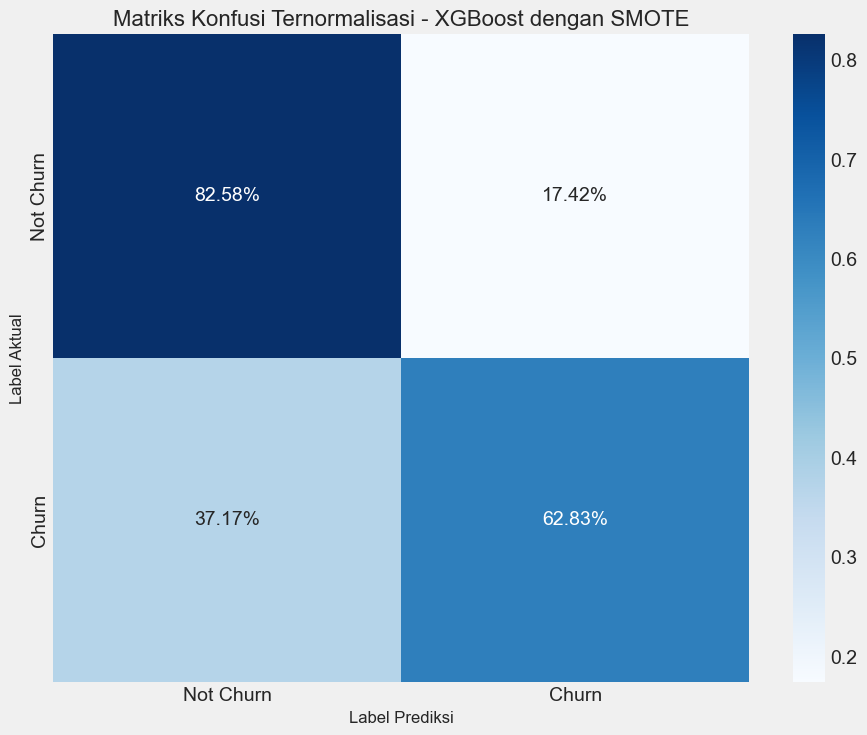

In [65]:
# Menghitung matriks konfusi
cm = confusion_matrix(y_test, y_pred_xgb)

# Normalisasi matriks konfusi
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualisasi matriks konfusi
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title('Matriks Konfusi Ternormalisasi - XGBoost dengan SMOTE', fontsize=16)
plt.ylabel('Label Aktual', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)
plt.show()

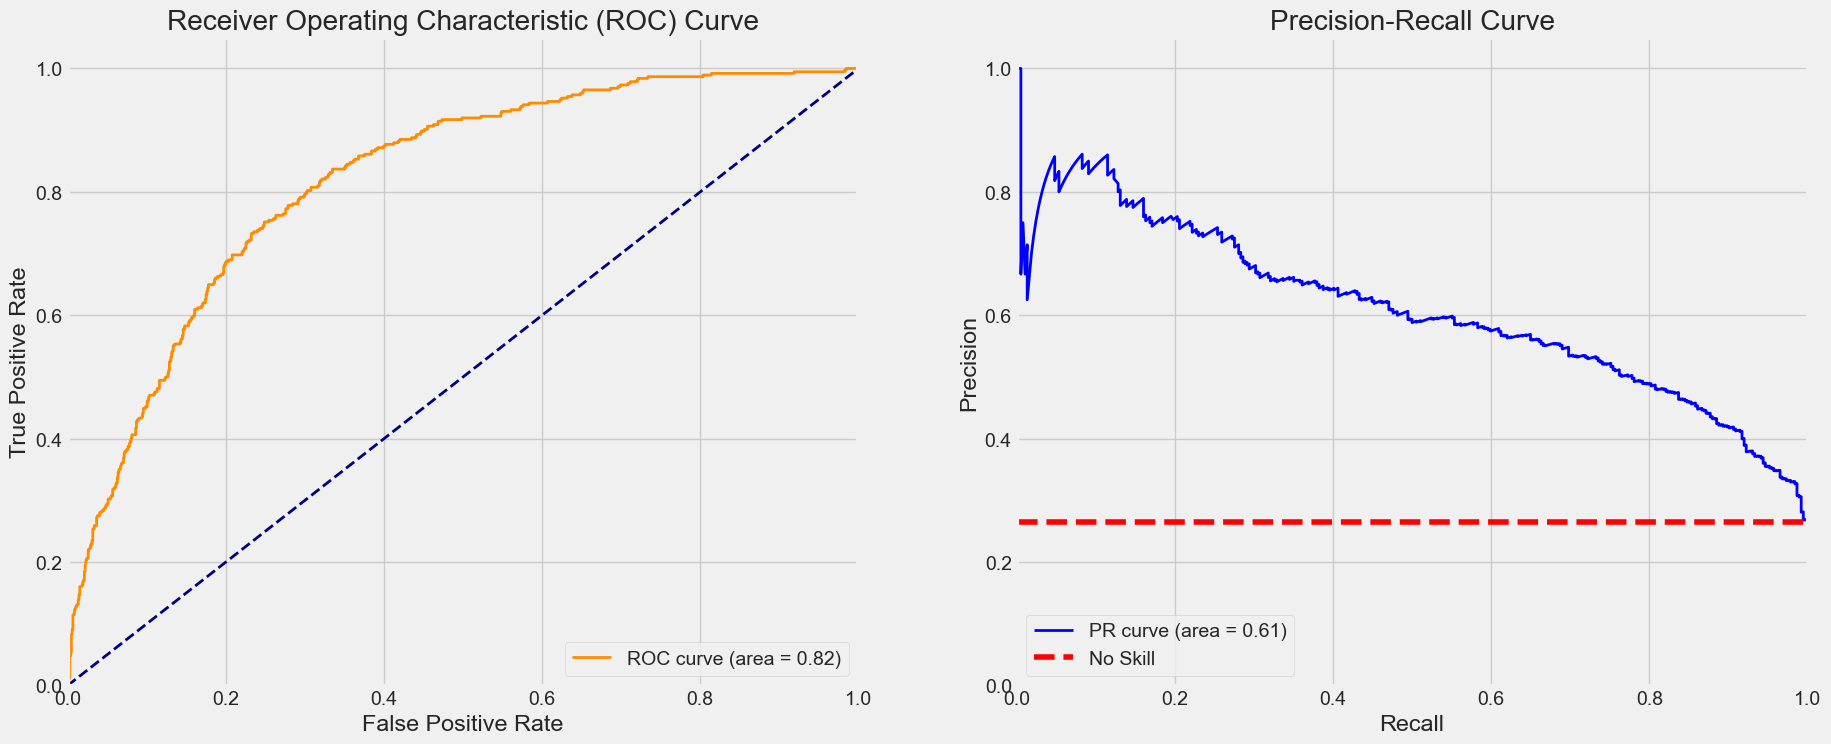

In [55]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Mendapatkan probabilitas prediksi untuk kelas positif (Churn=1)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Menghitung metrik untuk kurva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

# Menghitung metrik untuk kurva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob_xgb)
pr_auc = auc(recall, precision)

# Membuat plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot Kurva ROC
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # garis diagonal sebagai baseline
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Plot Kurva Precision-Recall
no_skill = len(y_test[y_test == 1]) / len(y_test)
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.show()